In [28]:
import numpy as np
import matplotlib.pyplot as plt
import random
from math import pi, sqrt
from scipy.special import erf 
import os

## cnot

100000


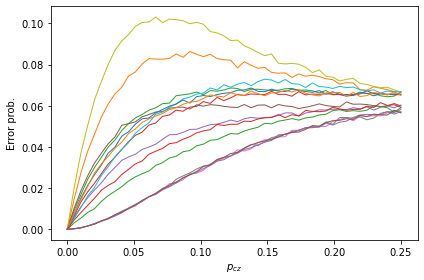

In [217]:
repeat = 100
pm_list =  [0.]

# plt.figure(1,figsize=(5,3))

for i_n, pm in enumerate(pm_list):
    first = True
    for i_rep in range(repeat):
        # fname = "data_dv_cnot/" + "new_pm_0_i_%d.npz" % (i_rep)
        fname = "data_dv_cnot/" + "new_pm_eq_pc_i_%d_mc.npz" % (i_rep)
    

        if os.path.exists(fname):
            npz_file = np.load(fname)
            pc_list, err_mc, Nrep = npz_file['pc_list'], npz_file['err_mc'], npz_file['Nrep']

            if first :
                first = False
                err_mc_avg = np.zeros((16,len(pc_list)))
                Ntot = 0

            err_mc_avg += err_mc*Nrep
            Ntot += Nrep
    if not first:
        err_mc_avg /= Ntot
        for i_xx in range(1,16):
            # plt.figure(i_xx)
            plt.plot(pc_list,err_mc_avg[i_xx,:],"-", color="C%d" % (i_xx), linewidth=1,label="MC, %d, %.2f" % (i_xx,pm))
            plt.xlabel(r"$p_{cz}$")
            plt.ylabel("Error prob.")
            # plt.grid()
            # plt.legend(frameon=False,markerscale=2)
            plt.tight_layout()
            # plt.grid()
            # plt.savefig("figs/qdot-threshold.pdf")
            # plt.show()
            
print(Ntot)

In [98]:

cnot = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])+0j

def pauli(s):
    s0 = np.matrix([[1.,0.],[0.,1.]])
    s1 = np.matrix([[0.,1.],[1.,0.]])
    s2 = np.matrix([[0.,-1.j],[1.j,0.]])
    s3 = np.matrix([[1.,0.],[0.,-1.]])
    if s == 'I':
        return s0 
    elif s =='X':
        return s1
    elif s == 'Y':
        return s2
    elif s == 'Z':
        return s3
    
def pauli_str_to_mat(string):
    U = pauli(string[0])
    for k in range(1,len(string)):
        U =np.kron(U, pauli(string[k]))
    return U

def error_channel(U_in, error_model):
    U_out = np.zeros([4,4])+0.j
    for i in range (16):
        U_out += error_model[i][1]*pauli_str_to_mat(error_model[i][0])@cnot@U_in@cnot@pauli_str_to_mat(error_model[i][0])
    return U_out

def fidelity_CNOT(error_model): # input a error model; out put the average fid. based on https://arxiv.org/pdf/quant-ph/0205035.pdf   
    err_list= {0: 'II', 1: 'ZI', 2: 'XI', 3: 'YI', 4: 'IZ', 5: 'ZZ', 6: 'XZ',\
          7: 'YZ', 8: 'IX', 9: 'ZX', 10: 'XX', 11: 'YX', 12: 'IY',\
          13: 'ZY', 14: 'XY', 15: 'YY'}
    fid = 0.2
    for i in range (16):
        U_in = pauli_str_to_mat(err_list[i])
        U_out = error_channel(U_in, error_model)
        fid += np.trace(cnot@np.conj(U_in.T)@cnot@U_out)/80
    return fid

In [195]:
# error_model = error_model_gkp(σc2, σgkp2, σm2, k=1, gate_type = 'CNOT')
err_list={0: 'II', 1: 'ZI', 2: 'XI', 3: 'YI', 4: 'IZ', 5: 'ZZ', 6: 'XZ',\
          7: 'YZ', 8: 'IX', 9: 'ZX', 10: 'XX', 11: 'YX', 12: 'IY',\
          13: 'ZY', 14: 'XY', 15: 'YY'}
    
fids_mc = []
for i_p, pc in enumerate(pc_list):
    err_model = []
    for i in range (16):
        err_model.append((err_list[i],err_mc_avg[i,i_p]))
    fids_mc.append(fidelity_CNOT(err_model))



[1.53147273e+01 7.63030303e-05]


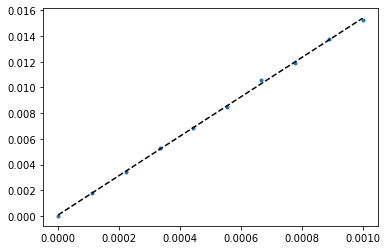

In [103]:
fids_mc_fine = np.real(np.array(fids_mc_fine))
plt.plot(pc_list,1-fids_mc_fine,".", label="Infidelity")

z = np.polyfit(pc_list, 1-fids_mc_fine, 1) 
print(z)
plt.plot(pc_list,z[0]*pc_list+z[1],"k--")

plt.show()

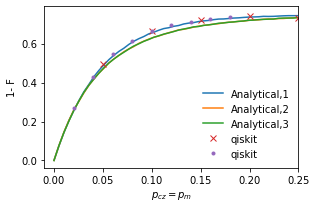

In [216]:
fids_mc = np.real(np.array(fids_mc))

plt.figure(figsize=(4.5,3))
# plt.plot(pc_list,1-fids_mc,"-", label="Analytical")
plt.plot(pc2_list,1-np.real(np.array(fids_mcz)),"-", label="Analytical,1")
plt.plot(pc2_list,1-np.real(np.array(fids_cz2)),"-", label="Analytical,2")
plt.plot(pc2_list,1-np.real(np.array(fids_cz)),"-", label="Analytical,3")


pc_list_qiskit = np.arange(1,10,1)*0.05
inFid_qiskit = np.array([0.495 , 0.6654, 0.7203, 0.7403, 0.7323, 0.7539, 0.7523, 0.7529,
       0.7517])

pc_list_qiskit2 = np.arange(1,10,1)*0.02

Fid_qiskit = np.array([0.7306,
 0.5722,
 0.45260000000000006,
 0.3858,
 0.33599999999999997,
 0.3024,
 0.28740000000000004,
 0.27449999999999997,
 0.261])

plt.plot(pc_list_qiskit,inFid_qiskit,"x", label="qiskit")
plt.plot(pc_list_qiskit2,1-Fid_qiskit,".", label="qiskit")

plt.legend(frameon=False)
plt.xlabel(r"$p_{cz}=p_m$")
plt.ylabel("1- F")
plt.xlim(-0.01,0.25)
plt.tight_layout()       
# plt.savefig("figs/cnot_dv_comparison.pdf")
plt.show()

## CNOT plot for draft

In [215]:
repeat = 100
pm_list =  [0.]

def file_reader(fname_in,mc=True,new=False):
    first = True
    for i_rep in range(repeat):
        # fname = "data_dv_cnot/" + "pm_%.2f_i_%d.npz" % (pm,i_rep)
        if mc:
            fname = fname_in+ "%d_mc.npz" % (i_rep)
        else:
            if new:
                fname = fname_in+ "%d_2.npz" % (i_rep)
            else:
                fname = fname_in+ "%d.npz" % (i_rep)
        
        # print(fname)
        if os.path.exists(fname):
            npz_file = np.load(fname)
            pc_list, err_mc, Nrep = npz_file['pc_list'], npz_file['err_mc'], npz_file['Nrep']

            if first :
                first = False
                err_mc_avg = np.zeros((16,len(pc_list)))
                Ntot = 0

            err_mc_avg += err_mc*Nrep
            Ntot += Nrep
    if not first:
        err_mc_avg /= Ntot
        print(Ntot)
    return pc_list,err_mc_avg
   
# error_model = error_model_gkp(σc2, σgkp2, σm2, k=1, gate_type = 'CNOT')
err_list={0: 'II', 1: 'ZI', 2: 'XI', 3: 'YI', 4: 'IZ', 5: 'ZZ', 6: 'XZ',\
          7: 'YZ', 8: 'IX', 9: 'ZX', 10: 'XX', 11: 'YX', 12: 'IY',\
          13: 'ZY', 14: 'XY', 15: 'YY'}
    

fname1 = "data_dv_cnot/" + "new_pm_eq_pc_i_"    
pc_list,err_mcz = file_reader(fname1)
fids_mcz = []
for i_p, pc in enumerate(pc_list):
    err_model = []
    for i in range (16):
        err_model.append((err_list[i],err_mcz[i,i_p]))
    fids_mcz.append(fidelity_CNOT(err_model))

# fname2 = "data_dv_cnot/" + "new_pm_0_i_"   
# fname2 = "data_dv_cnot/" + "new_pm_eq_pc_i_"  
fname2 = "data_dv_cnot/" + "last_cz_pm_eq_pc_i_" 
pc2_list, err_cz = file_reader(fname2,False)
fids_cz = []
for i_p, pc in enumerate(pc_list):
    err_model = []
    for i in range (16):
        err_model.append((err_list[i],err_cz[i,i_p]))
    fids_cz.append(fidelity_CNOT(err_model))

fname2 = "data_dv_cnot/" + "new_pm_eq_pc_i_"  
pc2_list, err_cz2 = file_reader(fname2,False,True)
fids_cz2 = []
for i_p, pc in enumerate(pc_list):
    err_model = []
    for i in range (16):
        err_model.append((err_list[i],err_cz2[i,i_p]))
    fids_cz2.append(fidelity_CNOT(err_model))

# fname3 = "data_dv_cnot/" + "new_pc_0_i_"    
# _, err_m = file_reader(fname3,False)
# fids_m = []
# for i_p, pc in enumerate(pc_list):
#     err_model = []
#     for i in range (16):
#         err_model.append((err_list[i],err_m[i,i_p]))
#     fids_m.append(fidelity_CNOT(err_model))


100000
100000
100000


In [212]:
## new files

fname1 = "data_dv_cnot/" + "last_cz_pm_eq_pc_i_" 
pc_list,err_mcz = file_reader(fname1,False)
fids_mcz = []
for i_p, pc in enumerate(pc_list):
    err_model = []
    for i in range (16):
        err_model.append((err_list[i],err_mcz[i,i_p]))
    fids_mcz.append(fidelity_CNOT(err_model))

# fname2 = "data_dv_cnot/" + "new_pm_0_i_"   
# fname2 = "data_dv_cnot/" + "new_pm_eq_pc_i_"  
fname2 = "data_dv_cnot/" + "last_cz_pm_0_i_" 
pc2_list, err_cz = file_reader(fname2,False)
fids_cz = []
for i_p, pc in enumerate(pc_list):
    err_model = []
    for i in range (16):
        err_model.append((err_list[i],err_cz[i,i_p]))
    fids_cz.append(fidelity_CNOT(err_model))
    
fname3 = "data_dv_cnot/" + "new_pc_0_i_"    
_, err_m = file_reader(fname3,False)
fids_m = []
for i_p, pc in enumerate(pc_list):
    err_model = []
    for i in range (16):
        err_model.append((err_list[i],err_m[i,i_p]))
    fids_m.append(fidelity_CNOT(err_model))

100000
100000
100000


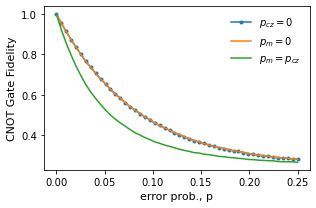

In [214]:
fids_mcz = np.real(np.array(fids_mcz))
fids_cz = np.real(np.array(fids_cz))
fids_m = np.real(np.array(fids_cz))


fsize = 11
plt.figure(figsize=(4.5,3))
plt.plot(pc2_list,fids_m,".-", color="C0", label="$p_{cz} =0$")
plt.plot(pc2_list,fids_cz,"-", color="C1",label="$p_m =0$")
plt.plot(pc2_list,fids_mcz,"-", color="C2", label="$p_m =p_{cz}$")

plt.legend(frameon=False)
plt.xlabel("error prob., p",fontsize=fsize)
plt.ylabel("CNOT Gate Fidelity",fontsize=fsize)
plt.tight_layout()       
plt.savefig("figs/dv_cnot_fidelity.pdf")
plt.show()

## hadamard

In [167]:

# def cz_err_model(p_c,i_c):
#     v_x = np.zeros(2,dtype=int)
#     v_z = np.zeros(2,dtype=int)
#     if i_c == 1:
#         v_x[0] = 1
#     elif i_c == 2:
#         v_x[0] = 1
#         v_z[0] = 1
#     elif i_c == 3:
#         v_z[0] = 1
#     elif i_c == 4:
#         v_z[1] = 1
#     elif i_c == 5:
#         v_x[0] = 1
#         v_z[1] = 1
#     elif i_c == 6:
#         v_x[0] = 1
#         v_z = np.ones(2,dtype=int)
#     elif i_c == 7:
#         v_z = np.ones(2,dtype=int)
#     if i_c ==0:
#         prob = 1-14*p_c/15
#     else:
#         prob = 2*p_c/15
#     return v_x, v_z, prob
# # pc_list = np.linspace(0,0.5,50)

# p_flip = 2*pc_list/3
# P_m = np.zeros((4,len(p_flip)))  # I, X, Z, Y
# P_m[0,:] = (1-p_flip)**4 + 2*p_flip**3 * (1-p_flip) + p_flip**2 * (1-p_flip)**2 
# P_m[1,:] = 2*p_flip * (1-p_flip)**3 + p_flip**2 * (1-p_flip)**2 + p_flip**4  
# P_m[2,:] = p_flip * (1-p_flip)**3 + 2* p_flip**2 * (1-p_flip)**2 + p_flip**3 * (1-p_flip)
# P_m[3,:] = p_flip * (1-p_flip)**3 + 2* p_flip**2 * (1-p_flip)**2 + p_flip**3 * (1-p_flip)

# P_tot = np.zeros((4,len(pc_list))) # I, X, Z, Y
# for i_p, p_c in enumerate(pc_list):
#     for i_1 in range(8):
#         vec_x = np.zeros(5,dtype=int)
#         vec_z = np.zeros(5,dtype=int)
#         vx, vz, p1 = cz_err_model(p_c,i_1)
#         vec_x[0:2] += vx
#         vec_z[0:2] += vz
#         for i_2 in range(8):
#             vx, vz, p2 = cz_err_model(p_c,i_2)
#             vec_x[1:3] += vx
#             vec_z[1:3] += vz
#             for i_3 in range(8):
#                 vx, vz, p3 = cz_err_model(p_c,i_3)
#                 vec_x[2:4] += vx
#                 vec_z[2:4] += vz
#                 for i_4 in range(8):
#                     vx, vz, p4 = cz_err_model(p_c,i_4)
#                     vec_x[3:5] += vx
#                     vec_z[3:5] += vz

#                     for i_0 in range(4):                        
#                         xcomp = (np.sum(vec_z[[0,2,3]])+ np.sum(vec_x[[2,3,4]])+ (i_0%2) )%2
#                         zcomp = ( np.sum(vec_z[[1,2,4]])+np.sum(vec_x[[1,2]])+ int(i_0/2) )%2

#                         P_tot[2*zcomp+xcomp,i_p] += P_m[i_0,i_p]*p1*p2*p3*p4

# Fid_H = 1-2/3*np.sum(P_tot[1:,:],axis=0)

# incorrect
def hadamard_err_prob(p_c,P_m):
    P_h = np.zeros(4) # I, X, Z, Y
    for i_1 in range(8):
        vec_x = np.zeros(5,dtype=int)
        vec_z = np.zeros(5,dtype=int)
        vx, vz, p1 = cz_err_model(p_c,i_1)
        vec_x[0:2] += vx
        vec_z[0:2] += vz
        for i_2 in range(8):
            vx, vz, p2 = cz_err_model(p_c,i_2)
            vec_x[1:3] += vx
            vec_z[1:3] += vz
            for i_3 in range(8):
                vx, vz, p3 = cz_err_model(p_c,i_3)
                vec_x[2:4] += vx
                vec_z[2:4] += vz
                for i_4 in range(8):
                    vx, vz, p4 = cz_err_model(p_c,i_4)
                    vec_x[3:5] += vx
                    vec_z[3:5] += vz

                    for i_0 in range(4):                        
                        xcomp = (np.sum(vec_z[[0,2,3]])+ np.sum(vec_x[[2,3,4]])+ (i_0%2) )%2
                        zcomp = ( np.sum(vec_z[[1,2,4]])+np.sum(vec_x[[1,2]])+ int(i_0/2) )%2

                        P_h[2*zcomp+xcomp] += P_m[i_0]*p1*p2*p3*p4

    return P_h

def hadamard_err_prob_new(p_c,P_m):
    P_h = np.zeros(4) # I, X, Z, Y
    for i_1 in range(8):
        vec_x = np.zeros((4,5),dtype=int)
        vec_z = np.zeros((4,5),dtype=int)
        vec_x[0,0:2], vec_z[0,0:2], p1 = cz_err_model(p_c,i_1)
        for i_2 in range(8):
            vec_x[1,1:3], vec_z[1,1:3], p2 = cz_err_model(p_c,i_2)
            for i_3 in range(8):
                vec_x[2,2:4], vec_z[2,2:4], p3 = cz_err_model(p_c,i_3)
                for i_4 in range(8):
                    vec_x[3,3:5], vec_z[3,3:5], p4 = cz_err_model(p_c,i_4)
                    vec_x_sum = np.sum(vec_x,axis=0) % 2
                    vec_z_sum = np.sum(vec_z,axis=0) % 2
                    for i_0 in range(4):                        
                        xcomp = (np.sum(vec_z_sum[[0,2,3]])+ np.sum(vec_x_sum[[2,3,4]])+ (i_0%2) )%2
                        zcomp = ( np.sum(vec_z_sum[[1,2,4]])+np.sum(vec_x_sum[[1,2]])+ int(i_0/2) )%2

                        P_h[2*zcomp+xcomp] += P_m[i_0]*p1*p2*p3*p4
    return P_h

# pc_list = np.linspace(0,0.001,10)
pc_list = np.linspace(0.0,0.5,50)
P_m = np.zeros(4)

# P_tot = np.zeros((4,len(pc_list))) # I, X, Z, Y
# for i_p, p_c in enumerate(pc_list):
#     p_flip = 2*p_c/3
#     P_m[0] = (1-p_flip)**4 + 2*p_flip**3 * (1-p_flip) + p_flip**2 * (1-p_flip)**2 
#     P_m[1] = 2*p_flip * (1-p_flip)**3 + p_flip**2 * (1-p_flip)**2 + p_flip**4  
#     P_m[2] = p_flip * (1-p_flip)**3 + 2* p_flip**2 * (1-p_flip)**2 + p_flip**3 * (1-p_flip)
#     P_m[3] = p_flip * (1-p_flip)**3 + 2* p_flip**2 * (1-p_flip)**2 + p_flip**3 * (1-p_flip)
#     P_tot[:,i_p] = hadamard_err_prob_new(p_c,P_m)
# inFid_mcz = 2/3*np.sum(P_tot[1:,:],axis=0)

P_tot2 = np.zeros((4,len(pc_list))) # I, X, Z, Y
for i_p, p_c in enumerate(pc_list):
    p_flip = 2*p_c/3
    P_m[0] = (1-p_flip)**4 + 2*p_flip**3 * (1-p_flip) + p_flip**2 * (1-p_flip)**2 
    P_m[1] = 2*p_flip * (1-p_flip)**3 + p_flip**2 * (1-p_flip)**2 + p_flip**4  
    P_m[2] = p_flip * (1-p_flip)**3 + 2* p_flip**2 * (1-p_flip)**2 + p_flip**3 * (1-p_flip)
    P_m[3] = p_flip * (1-p_flip)**3 + 2* p_flip**2 * (1-p_flip)**2 + p_flip**3 * (1-p_flip)
    P_tot2[:,i_p] = hadamard_err_prob(p_c,P_m)
inFid_mcz2 = 2/3*np.sum(P_tot2[1:,:],axis=0)

100000


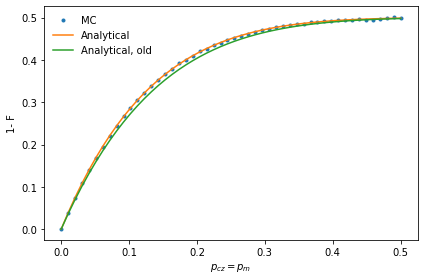

In [169]:
# plt.plot(pc_list,1-np.real(np.array(fids)),)

repeat = 100
fname1 = "data_dv_H/" + "pm_eq_pc_i_"    
pc_list,err_mcz = file_reader(fname1,False)
inFid_mcz_mc = 2/3*np.sum(err_mcz[1:,:],axis=0)

plt.plot(pc_list,inFid_mcz_mc,".",label="MC")
plt.plot(pc_list,inFid_mcz,label="Analytical")
plt.plot(pc_list,inFid_mcz2,label="Analytical, old")

# print(z)
# plt.plot(pc_list,z[0]*pc_list+z[1],"k--")
# plt.ylim(0,0.8)

# plt.plot(pc_list,1/4+0*pc_list,"k--")
plt.legend(frameon=False)
plt.xlabel(r"$p_{cz}=p_m$")
plt.ylabel("1- F")
plt.tight_layout()       
# plt.savefig("figs/fidelity_pm_eq_pc.pdf")
plt.show()